# 数据预处理部分

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# 常量定义
player_cols = ['X', 'Y', 'X_dir', 'Y_dir', 'X_S', 'Y_S', 'S', 'A', 'IsRusher', 'IsOnOffense']
play_cols = ['X_rusher', 'Y_rusher', 'YardLine_std']
results = {}

# 加载数据
train = pd.read_csv('train.csv', dtype={'WindSpeed': 'object'})
train.shape

(509762, 49)

In [3]:
def reorient(train, flip_left):
    # 进攻方向
    train['ToLeft'] = train.PlayDirection == "left"
    train['IsRusher'] = train['NflId'] == train['NflIdRusher']
    
    # 修正队名
    train.loc[train.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
    train.loc[train.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"
    
    train.loc[train.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
    train.loc[train.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"
    
    train.loc[train.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
    train.loc[train.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"
    
    train.loc[train.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
    train.loc[train.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"
    
    # 进攻方
    train['TeamOnOffense'] = "home"
    train.loc[train.PossessionTeam != train.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    train['IsOnOffense'] = train.Team == train.TeamOnOffense # Is player on offense?
    
    # 左半场向右进攻或者右半场向左进攻，修正码线
    train['YardLine_std'] = 100 - train.YardLine
    train.loc[train.FieldPosition.fillna('') == train.PossessionTeam, 'YardLine_std'] = train.loc[train.FieldPosition.fillna('') == train.PossessionTeam, 'YardLine']
    
    # 修正X，Y
    train.loc[train.ToLeft, 'X'] = 120 - train.loc[train.ToLeft, 'X'] 
    train.loc[train.ToLeft, 'Y'] = 160/3 - train.loc[train.ToLeft, 'Y'] 
    
    # Orientation好像后面没有用到
    train.loc[train.ToLeft, 'Orientation'] = np.mod(180 + train.loc[train.ToLeft, 'Orientation'], 360)
    
    # 修正角度，水平向右为0度
    train['Dir'] = 90 - train.Dir
    
    # Dir为NaN的情况
    train.loc[train.IsOnOffense, 'Dir'] = train.loc[train.IsOnOffense, 'Dir'].fillna(0).values
    train.loc[~train.IsOnOffense, 'Dir'] = train.loc[~train.IsOnOffense, 'Dir'].fillna(180).values
    
    # some data cleaning that was shared by top teams, namely using S = 10 * Dis, and averaging A in 2017
    # 这个感觉有点扯
    # train['S'] = 10 * train['Dis']
    # train.loc[train.Season == 2017, 'A'] = train.loc[train.Season == 2017, 'A'].mean()
    
    # 全部转成向右进攻
    if flip_left:
        train.loc[train.ToLeft, 'Y'] = 160/3 - train.loc[train.ToLeft, 'Y']
        train.loc[train.ToLeft, 'Dir'] = 180 + train.loc[train.ToLeft, 'Dir']
        
    train['X_dir'] = np.cos( (np.pi / 180) * train.Dir)
    train['Y_dir'] = np.sin( (np.pi / 180) * train.Dir)
    train['X_S'] = train.X_dir * train.S
    train['Y_S'] = train.Y_dir * train.S
    train['X_A'] = train.X_dir * train.A
    train['Y_A'] = train.Y_dir * train.A
    
    # 转换成英寸
    train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    train['BMI'] = (train['PlayerWeight'] * 703) / (train['PlayerHeight'] ** 2)
    train['Energy'] = train['PlayerWeight'] * (train['S'] ** 2) 
    # train.loc[train['Season'] == 2017, 'S'] = (train['S'][train['Season'] == 2017] - 2.4355) / 1.2930 * 1.4551 + 2.7570
    
    train['time_step'] = 0.0
    train = train.sort_values(by=['PlayId', 'IsOnOffense', 'IsRusher', 'Y']).reset_index(drop=True)

    return  train

In [4]:
# reorient修正跑动方向
train_reorient = reorient(train.copy(), flip_left=True)
len_train_reorient = len(train_reorient) // 22
print("len_train_reorient:", len_train_reorient)

len_train_reorient: 23171


In [5]:
def add_features(train):
    df = train[train.IsRusher][['PlayId', 'time_step', 'X', 'Y']].copy()
    df.columns = ['PlayId', 'time_step', 'X_rusher', 'Y_rusher']
    train = train.merge(df, how='left', on=['PlayId', 'time_step'])
    #train.loc[~train.IsRusher, 'X'] = train.loc[~train.IsRusher, 'X'] - train.loc[~train.IsRusher, 'X_rusher']
    #train.loc[~train.IsRusher, 'Y'] = train.loc[~train.IsRusher, 'Y'] - train.loc[~train.IsRusher, 'Y_rusher']
    
    # 转换到rusher的距离
    train.X -= train.X_rusher
    train.Y -= train.Y_rusher
    
    #train.drop(['Orientation', 'Dir', 'TeamOnOffense', 'YardLine', 'left'], axis=1, inplace=True)
    return train

def time_forward(train, time_step):
    train = train.copy()
    train['X'] = train['X'] + time_step * train['X_S'] + 0.5 * time_step**2 * train['X_A']
    train['Y'] = train['Y'] + time_step * train['Y_S'] + 0.5 * time_step**2 * train['Y_A']
    #  速度
    x_s = np.clip(train['X_S'] + time_step * train['X_A'], -14, 14)
    y_s = np.clip(train['Y_S'] + time_step * train['Y_A'], -14, 14)
    if 1:
        # 加速度
        train['X_A'] = np.clip(train['X_A'] * train['X_S'] / (x_s), -10, 10)
        train['Y_A'] = np.clip(train['Y_A'] * train['Y_S'] / (y_s), -10, 10)
    train['X_S'] = x_s
    train['Y_S'] = y_s
    train['time_step'] = time_step
    return train

def augment_data(train_reorient, time_steps):
    train_reorient = pd.concat(time_forward(train_reorient, time_step) for time_step in time_steps)
    train_reorient = add_features(train_reorient)
    return train_reorient

In [6]:
# augment_data通过计算0.3秒和0.6秒后的位置/速度/加速度，增加训练集
time_steps = [0, 0.3, 0.6]
train_reorient = augment_data(train_reorient, time_steps)

In [7]:
# 一场比赛22名队员位置信息
df = train_reorient[player_cols]
df.head(22)

,X,Y,X_dir,Y_dir,X_S,Y_S,S,A,IsRusher,IsOnOffense
0,4.64,-13.89,0.607514,-0.794309,0.674341,-0.881683,1.11,0.83,False,False
1,5.38,-11.80,1.000000,-0.000698,1.240000,-0.000866,1.24,0.74,False,False
2,3.69,-6.53,-0.996179,0.087330,-1.006141,0.088203,1.01,0.32,False,False
3,22.12,-3.63,-0.822243,-0.569136,-0.213783,-0.147975,0.26,1.86,False,False
4,7.29,-2.83,-0.962975,0.269592,-0.404449,0.113229,0.42,0.54,False,False
5,4.60,-1.63,0.997391,-0.072194,0.718121,-0.051980,0.72,0.73,False,False
6,4.08,2.11,0.320613,0.947210,0.134657,0.397828,0.42,1.35,False,False
7,4.75,2.67,0.386389,0.922336,0.471395,1.125250,1.22,0.59,False,False
8,4.84,4.31,-0.049198,0.998789,-0.083145,1.687953,1.69,1.13,False,False
9,9.43,4.89,-0.270432,0.962739,-0.492187,1.752185,1.82,2.43,False,False


In [8]:
# 2017年的数据不用于交叉验证，所以找到2017年位置
df = train_reorient[player_cols]
len_2017 = train[train.Season == 2017].shape[0] // 22
print("len_2017:", len_2017)

len_2017: 11900


In [9]:
from sklearn.preprocessing import StandardScaler
from numba import jit
import matplotlib.pyplot as plt

In [10]:
# X_players
ss_players = StandardScaler()
X_players = df.values.astype('float32') 
X_players = ss_players.fit_transform(df)
X_players = X_players.reshape((-1, 22, len(player_cols)))
X_players.shape

(69513, 22, 10)

In [11]:
# X_play
X_play = train_reorient[play_cols].values[::22]  # 间隔22行取值
ss_play = StandardScaler()
X_play = ss_play.fit_transform(X_play)
X_play.shape

(69513, 3)

In [12]:
@jit
def get_dmat(X, Y):
    dmat = np.zeros((22, 22))
    for i in range(22):
        for j in range(i+1, 22):
            d = np.sqrt((X[i] - X[j])**2 + (Y[i] - Y[j])**2)
            dmat[i, j] = d
            dmat[j, i] = d
    dmat = dmat.reshape((1, 22, 22))
    return dmat

In [13]:
# dmats
X,Y = train_reorient.X.values, train_reorient.Y.values
dmats = [get_dmat(X[i:i+22], Y[i:i+22]) for i in range(0, train_reorient.shape[0], 22)]
dmats = np.vstack(dmats).reshape((-1, 22, 22))
dmats.shape

(69513, 22, 22)

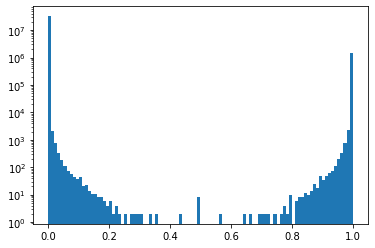

In [14]:
# 距离平方的倒数评价player之间的影响
inv_dmats = 1. / (1e-2 + dmats)**2

# 每个player相对于其他距离归一化
inv_dmats /= inv_dmats.sum(axis=2, keepdims=True)

_ = plt.hist(inv_dmats.ravel(), bins=100, log=True)

In [15]:
del train

# 训练部分

模型用的特征：
- Player features: 'X', 'Y', 'X_dir', 'Y_dir', 'X_S', 'Y_S', 'S', 'A', 'IsRusher', 'IsOnOffense' (X, Y是相对与Rusher的相对距离)
- Distance matrix
- Play features: 比赛信息，包括rusher的位置，码线等等

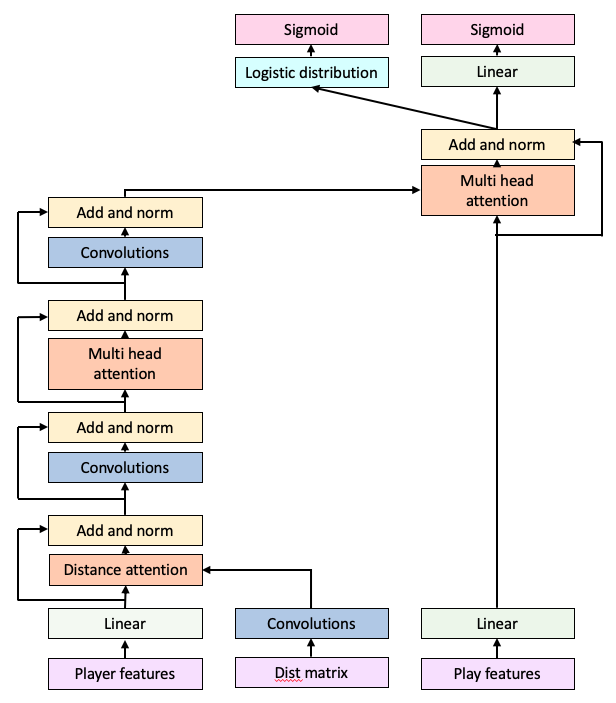

In [16]:
import tensorflow as tf

from keras.models import Model
from keras.layers import Layer, BatchNormalization, Activation, Add, Multiply, Dot
from keras.layers import Embedding, Permute, Reshape, Input
from keras.layers.core import Dropout, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.isotonic import IsotonicRegression

import random as rn

Using TensorFlow backend.


In [17]:
y_mae = train_reorient['Yards'].values[::22]
y_mean = np.median(y_mae)

# 199表示yards从-100到100
# 这里对预测值进行了处理，大于等于Yards的位置都置为1，像是一个累积分布
y_crps = np.zeros(shape=(y_mae.shape[0], 199))
for i,yard in enumerate(y_mae):
    y_crps[i, yard+99:] = 1
    
yardline = train_reorient['YardLine_std'].values[::22]

In [18]:
# Layer Normalization from github
class LayerNormalization(Layer):

    def __init__(self,
                 center=True,
                 scale=True,
                 epsilon=None,
                 gamma_initializer='ones',
                 beta_initializer='zeros',
                 gamma_regularizer=None,
                 beta_regularizer=None,
                 gamma_constraint=None,
                 beta_constraint=None,
                 **kwargs):
        """Layer normalization layer
        See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
        :param center: Add an offset parameter if it is True.
        :param scale: Add a scale parameter if it is True.
        :param epsilon: Epsilon for calculating variance.
        :param gamma_initializer: Initializer for the gamma weight.
        :param beta_initializer: Initializer for the beta weight.
        :param gamma_regularizer: Optional regularizer for the gamma weight.
        :param beta_regularizer: Optional regularizer for the beta weight.
        :param gamma_constraint: Optional constraint for the gamma weight.
        :param beta_constraint: Optional constraint for the beta weight.
        :param kwargs:
        """
        super(LayerNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.center = center
        self.scale = scale
        if epsilon is None:
            epsilon = K.epsilon() * K.epsilon()
        self.epsilon = epsilon
        self.gamma_initializer = keras.initializers.get(gamma_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.gamma_regularizer = keras.regularizers.get(gamma_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.gamma_constraint = keras.constraints.get(gamma_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        self.gamma, self.beta = None, None

    def get_config(self):
        config = {
            'center': self.center,
            'scale': self.scale,
            'epsilon': self.epsilon,
            'gamma_initializer': keras.initializers.serialize(self.gamma_initializer),
            'beta_initializer': keras.initializers.serialize(self.beta_initializer),
            'gamma_regularizer': keras.regularizers.serialize(self.gamma_regularizer),
            'beta_regularizer': keras.regularizers.serialize(self.beta_regularizer),
            'gamma_constraint': keras.constraints.serialize(self.gamma_constraint),
            'beta_constraint': keras.constraints.serialize(self.beta_constraint),
        }
        base_config = super(LayerNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        shape = input_shape[-1:]
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint,
                name='gamma',
            )
        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint,
                name='beta',
            )
        super(LayerNormalization, self).build(input_shape)

    def call(self, inputs, training=None):
        mean = K.mean(inputs, axis=-1, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        outputs = (inputs - mean) / std
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
        return outputs

In [19]:
# Scale Layer
# from keras.engine.topology import Layer
class ScaleLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(ScaleLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ScaleLayer, self).build(input_shape) 

    def call(self, x):
        xx = K.arange(-99, 100, dtype=tf.float32)
        mu = y_mean + tf.reshape(x[:, 0], (-1, 1))
        sigma_minus = tf.identity(K.exp(0.5 * tf.reshape(x[:, 1], (-1, 1))), name="sigma")
        sigma_plus = tf.identity(K.exp(0.5 * tf.reshape(x[:, 2], (-1, 1))), name="sigma")
        xx = tf.subtract(xx, mu)
        pcf = tf.where(xx >= 0, tf.divide (xx, sigma_plus),  tf.divide (xx, sigma_minus))
        return pcf

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [20]:
# dist shape: (None, 22, 22), players shape: (None, 22, 64)
# return (None, 22, 64)
def dist_mult(dist, players):
    res = Lambda(lambda c: K.batch_dot(c[0], c[1]))([dist, players])
    return res

# dist(None, 22, 22), players(None, 22, 64)
# dist(None, 22, 22) -> Reshape(None, 22, 22, 1) -> Conv2D(None, 22, 22, 16) -> Conv2D(None, 22, 22, 1)
#   -> Reshape(None, 22, 22) -> Add(None, 22, 22) -> LN(None, 22, 22) -> dist_mult(None, 22, 64)
#   -> Add(None, 22, 64) -> LN(None, 22, 64) -> Dropout(None, 22, 64)
def dist_attention(dist, players, dropout):
    if 1:
        dist1 = Reshape((22, 22, 1))(dist)
        dist1 = Conv2D(16, 1, activation='relu', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(dist1)
        dist1 = Conv2D(1, 1, activation='relu', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(dist1)
        dist1 = Reshape((22, 22))(dist1)
        dist = Add()([dist, dist1])
    dist = LayerNormalization()(dist)
    att = dist_mult(dist, players, )
    x_player = Add()([players, att])
    x_player = LayerNormalization()(x_player)
    if dropout > 0:
        x_player = Dropout(dropout)(x_player)
    return x_player

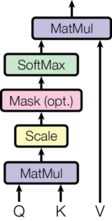

In [21]:
# multi_head_self_attention
# x_inner(None, 22, 64), x_outer(None, 22, 64), n_factor: 16
# x_Q(None, 22, 16), x_K(None, 22, 16), x_V(None, 22, 16), att(None, 22, 16)

# multi_head_outer_attention
# x_inner(None, 1, None), x_outer(None, 22, 64), n_factor: 16
# x_Q(None, 1, 16), x_K(None, 22, 16), x_V(None, 22, 16), att(None, 1, 16)
def attention(x_inner, x_outer, n_factor, dropout):
    x_Q =  Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_inner)
    x_K =  Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_V =  Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_KT = Permute((2, 1))(x_K)
    res = Lambda(lambda c: K.batch_dot(c[0], c[1]) / np.sqrt(n_factor))([x_Q, x_KT])
    att = Lambda(lambda c: K.softmax(c, axis=-1))(res)
    att = Lambda(lambda c: K.batch_dot(c[0], c[1]))([att, x_V])
    return att

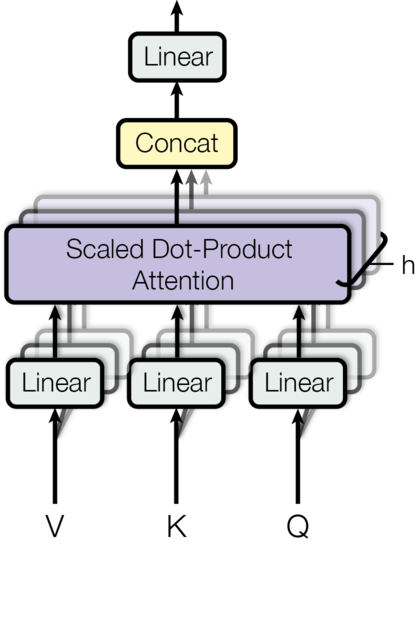

In [22]:
# heads(4 * (None, 22, 16)) -> Concatenate(None, 22, 64) -> Dense(None, 22, 64)
#   -> Add(None, 22, 64) -> LN(None, 22, 64) -> Dropout(None, 22, 64)
def multi_head_self_attention(x, n_factor, n_head, dropout):
    if n_head == 1:
        att = attention(x, x, n_factor, dropout)
    else:
        n_factor_head = n_factor // n_head
        heads = [attention(x, x, n_factor_head, dropout) for i in range(n_head)]
        att = Concatenate()(heads)
        att = Dense(n_factor, 
                      kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform',
                     )(att)
    x = Add()([x, att])
    x = LayerNormalization()(x)
    if dropout > 0:
        x = Dropout(dropout)(x)
    return x

# heads(4 * (None, 1, 16)) -> Concatenate(None, 1, 64) -> Dense(None, 1, 64)
#   -> Add(None, 1, 64) -> LN(None, 1, 64) -> Dropout(None, 1, 64)
def multi_head_outer_attention(x_inner, x_outer, n_factor, n_head, dropout):
    if n_head == 1:
        att = attention(x_inner, x_outer, n_factor, dropout)
    else:
        n_factor_head = n_factor // n_head
        heads = [attention(x_inner, x_outer, n_factor_head, dropout) for i in range(n_head)]
        att = Concatenate()(heads)
        att = Dense(n_factor, 
                      kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform',
                     )(att)
    x_inner = Add()([x_inner, att])
    x_inner = LayerNormalization()(x_inner)
    if dropout > 0:
        x = Dropout(dropout)(x_inner)
    return x

In [23]:
# squeeze and excitation
def se_bloc(in_bloc, ch, ratio):
    # in_bloc (None, 22, 64)
    x = GlobalAveragePooling1D()(in_bloc) # (None, 64)
    x = Dense(ch//ratio, activation='relu')(x) # (None, 32)
    x = Dense(ch, activation='sigmoid')(x) # (None, 64)
    x = Multiply()([in_bloc, x]) # (None, 22, 64)
    return Add()([x, in_bloc])

def conv_bloc(players, n_factor, n_hidden, se_ratio, dropout):
    players0 = players
    # (None, 22, 128)
    players = Conv1D(n_hidden, 1, activation='relu', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(players)
    #(None, 22, 64)
    players = Conv1D(n_factor, 1, activation='relu', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(players)
    # (None, 22, 64)
    players = Add()([players0, players])
    # (None, 22, 64)
    players = se_bloc(players, n_factor, se_ratio)
    players = LayerNormalization()(players)
    if dropout > 0:
        players = Dropout(dropout)(players)
    return players

模型的输出有两个，分别是out1和out2。out2是JFP观察yard的累积分布函数，像是一个两段直线。Dense(4)得到四个数字分别代表两段斜率和交汇点坐标(https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/119430)

In [24]:
# build model
def get_model(n_player, n_factor, n_loop, n_head, n_hidden, se_ratio, dropout, n_player_cols, n_play_cols):
    input_players = Input((n_player, n_player_cols), name="players") # (None, 22, 10)
    input_dmats = Input((n_player, n_player), name="inv_dist") # (None, 22, 22)
    input_play = Input((n_play_cols,), name="plays") # (None, 3)

    x_player = input_players
    x_player = Conv1D(n_factor, 1)(x_player) # (None, 22, 10) -> (None, 22, 64)
    x_player = LayerNormalization()(x_player)

    for l in range(n_loop):
        # (None, 22, 64)
        x_player = dist_attention(input_dmats, x_player, dropout)
        # (None, 22, 64)
        x_player = conv_bloc(x_player, n_factor, n_hidden, se_ratio, dropout)

        # (None, 22, 64)
        x_player = multi_head_self_attention(x_player, n_factor, n_head, dropout)
        # (None, 22, 64)
        x_player = conv_bloc(x_player, n_factor, n_hidden, se_ratio, dropout)
    
    x_play = Dense(n_factor)(input_play) #(None, 64)
    x_play = Reshape((1, -1))(x_play) #(None, 1, None)
    
    # (None, 1, 64)
    readout = multi_head_outer_attention(x_play, x_player, n_factor, n_head, dropout)
    readout = Flatten()(readout)

    # (None, 199)
    out1 = Dense(199, activation='sigmoid')(readout)
    # (None, 4)
    readout = Dense(4)(readout)
    # (None, 199)
    readout = ScaleLayer(output_dim=199)(readout)
    out2 = Activation('sigmoid')(readout)
    return Model(inputs=[input_players, input_dmats, input_play], outputs=[out1, out2])

In [25]:
n_player = 22
n_factor = 64
se_ratio = 4
n_loop = 1
n_head = 4
n_hidden = 2*n_factor
dropout = 0.25
n_player_cols = len(player_cols)
n_play_cols = len(play_cols)
model = get_model(n_player, n_factor, n_loop, n_head, n_hidden, se_ratio, dropout, n_player_cols, n_play_cols)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inv_dist (InputLayer)           (None, 22, 22)       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 22, 22, 1)    0           inv_dist[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 22, 22, 16)   32          reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 1)    17          conv2d_1[0][0]                   
____________________________________________________________________________________________

开始训练

In [26]:
# 定义metric为均方误差
def crps(y_true, y_pred):
    stops = np.arange(-99, 100)
    unit_steps = stops >= y_true.reshape(-1, 1)
    crps = np.mean((y_pred - unit_steps)**2)
    return crps

In [27]:
simulate_test = False

if simulate_test:
    len_data = X_players.shape[0]
    len_train = int(0.9 * len_data)
else:
    len_data = X_players.shape[0]
    len_train = len_data

X_players_train, X_players_test = X_players[:len_train], X_players[len_train:]
inv_dmats_train, inv_dmats_test = inv_dmats[:len_train], inv_dmats[len_train:]
X_play_train, X_play_test = X_play[:len_train], X_play[len_train:]
y_mae_train, y_mae_test = y_mae[:len_train], y_mae[len_train:]
y_crps_train, y_crps_test = y_crps[:len_train], y_crps[len_train:]
yardline_train, yardline_test = yardline[:len_train], yardline[len_train:]

In [28]:
kf = KFold(n_splits=2, shuffle=False)
ind_2017 = np.arange(len_2017)
def add_2017(x,y):
    x = np.concatenate((ind_2017, x +  len_2017))
    y = y + len_2017
    return x,y

indices = [add_2017(x, y) for x, y in kf.split(X_players_train[len_2017:len_train_reorient], 
                                               y_mae_train[len_2017:len_train_reorient])]

n_steps = len(time_steps)

def augment_indices(x, y, time_steps):
    x_a = np.concatenate([x + i*len_train_reorient for i in range(n_steps)])
    y_a = np.concatenate([y + i*len_train_reorient for i in range(n_steps)])
    return x_a, y_a

indices = [augment_indices(x, y, time_steps) for x,y in indices ]
indices = [(i, ind) for i,ind in enumerate(indices)]

w = np.ones(len_train_reorient)
w[:len_2017] = 0.5
w = np.concatenate([w for i in range(n_steps)])

In [29]:
def init_seeds(seed):

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.random.set_seed(seed)

    # sess = tf.Session(graph=tf.get_default_graph())
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
    # K.set_session(sess)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [30]:
def nondecreasing(x):
    X_ir = np.arange(199).astype('float64')
    ir = IsotonicRegression(0, 1)
    x = ir.fit_transform(X_ir, x.astype('float64'))        
    return x

def post_process(y_pred, yardline_train, time_steps):
    upper = 100 - yardline_train
    lower = - yardline_train
    for i in range(y_pred.shape[0]):
        y_pred[i, 99 + upper[i]:] = 1
        y_pred[i, :99 + lower[i]] = 0
        y_pred[i] = nondecreasing(y_pred[i].ravel())
    if 1:
        n_steps = len(time_steps)
        len_y_pred = len(y_pred) // n_steps
        y_pred = np.mean([y_pred[len_y_pred * i: len_y_pred * (i+1)] for i in range(n_steps)], axis=0) 
    return y_pred

In [31]:
name = 'nn'
results[name] = {'crps': [], 'y_test': [], 'imp': [], 'models': []}

try:
    del sess
except:
    pass

sess = init_seeds(0)

pred_test = []


for index in indices:
    if 0 and index[0] < 10:
        continue
    train_idx, val_idx = index[1]
    train_players, train_inv_dmats, train_play, train_y, = (X_players_train[train_idx], 
                                                            inv_dmats_train[train_idx], 
                                                            X_play_train[train_idx], 
                                                            y_crps_train[train_idx],) 
    val_players, val_inv_dmats, val_play, val_y, = (X_players_train[val_idx], 
                                                    inv_dmats_train[val_idx], 
                                                    X_play_train[val_idx], 
                                                    y_crps_train[val_idx], )
    w_train = w[train_idx]

    n_player = 22
    n_factor = 64
    se_ratio = 2
    n_loop = 1
    n_head = 4
    n_hidden = 2 * n_factor
    dropout = 0.25
    n_player_cols = len(player_cols)
    n_play_cols = len(play_cols)
    model = get_model(n_player, n_factor, n_loop, n_head, n_hidden, se_ratio, dropout, n_player_cols, n_play_cols)
    
    if 1:
        opm = keras.optimizers.Adam(lr=1e-3)
        #opm = RAdam(warmup_proportion=0.1, min_lr=1e-5)
        model.compile(loss='mse', optimizer=opm, metrics=[])
        es = EarlyStopping(monitor='val_loss', mode='min',
                            restore_best_weights=True, verbose=0, patience=21)
        lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10,
                               verbose=0, mode='min', min_delta=0.00001)
        history = model.fit([train_players, train_inv_dmats, train_play], [train_y, train_y], 
                        verbose=2, batch_size=256, epochs=500, 
                        callbacks=[es,lr], 
                        validation_data=[[val_players, val_inv_dmats, val_play], [val_y, val_y]],
                        sample_weight=[w_train, w_train])
    
    X_ir = np.arange(199).astype('float64')
    print(val_players.shape, val_inv_dmats.shape)

    y_pred = model.predict([val_players, val_inv_dmats, val_play])
    y_pred = (y_pred[0] + y_pred[1])/2.
    score0 = crps(y_mae_train[val_idx], y_pred)
    y_pred = post_process(y_pred, yardline_train[val_idx], time_steps)
    score1 = crps(y_mae_train[val_idx][:len(y_pred)], y_pred)
    print(' val fold:', index[0], score0)
    print(' val fold:', index[0], score1)
    if score0 < score1:
        break
    results[name]['models'].append(model)
    results[name]['crps'].append(score1)
    #results[name]['imp'].append(model.feature_importances_)
    if simulate_test:
        y_pred = model.predict([X_players_test, inv_dmats_test, X_play_test])
        y_pred = (y_pred[0] + y_pred[1])/2.
        score0 = crps(y_mae_test, y_pred)
        y_pred = post_process(y_pred, yardline_test, time_steps)
        score1 = crps(y_mae_test[:len(y_pred)], y_pred)
        print('test fold:', index[0], score0)
        print('test fold:', index[0], score1)
        pred_test.append(y_pred)
    print('*' * 40)
print('Folds:', results[name]['crps'])
print('Average:', np.mean(results[name]['crps']))

Train on 52605 samples, validate on 16908 samples
Epoch 1/500
 - 28s - loss: 0.0331 - dense_17_loss: 0.0232 - activation_2_loss: 0.0098 - val_loss: 0.0292 - val_dense_17_loss: 0.0148 - val_activation_2_loss: 0.0144
Epoch 2/500
 - 25s - loss: 0.0193 - dense_17_loss: 0.0098 - activation_2_loss: 0.0096 - val_loss: 0.0285 - val_dense_17_loss: 0.0144 - val_activation_2_loss: 0.0141
Epoch 3/500
 - 24s - loss: 0.0186 - dense_17_loss: 0.0094 - activation_2_loss: 0.0092 - val_loss: 0.0290 - val_dense_17_loss: 0.0145 - val_activation_2_loss: 0.0145
Epoch 4/500
 - 25s - loss: 0.0179 - dense_17_loss: 0.0090 - activation_2_loss: 0.0089 - val_loss: 0.0280 - val_dense_17_loss: 0.0140 - val_activation_2_loss: 0.0140
Epoch 5/500
 - 24s - loss: 0.0176 - dense_17_loss: 0.0088 - activation_2_loss: 0.0088 - val_loss: 0.0280 - val_dense_17_loss: 0.0140 - val_activation_2_loss: 0.0140
Epoch 6/500
 - 23s - loss: 0.0174 - dense_17_loss: 0.0087 - activation_2_loss: 0.0087 - val_loss: 0.0279 - val_dense_17_loss:

Epoch 12/500
 - 23s - loss: 0.0168 - dense_26_loss: 0.0084 - activation_3_loss: 0.0084 - val_loss: 0.0284 - val_dense_26_loss: 0.0142 - val_activation_3_loss: 0.0141
Epoch 13/500
 - 23s - loss: 0.0167 - dense_26_loss: 0.0084 - activation_3_loss: 0.0084 - val_loss: 0.0286 - val_dense_26_loss: 0.0142 - val_activation_3_loss: 0.0143
Epoch 14/500
 - 23s - loss: 0.0167 - dense_26_loss: 0.0083 - activation_3_loss: 0.0084 - val_loss: 0.0284 - val_dense_26_loss: 0.0141 - val_activation_3_loss: 0.0142
Epoch 15/500
 - 23s - loss: 0.0167 - dense_26_loss: 0.0083 - activation_3_loss: 0.0084 - val_loss: 0.0283 - val_dense_26_loss: 0.0141 - val_activation_3_loss: 0.0141
Epoch 16/500
 - 23s - loss: 0.0166 - dense_26_loss: 0.0083 - activation_3_loss: 0.0083 - val_loss: 0.0284 - val_dense_26_loss: 0.0141 - val_activation_3_loss: 0.0142
Epoch 17/500
 - 23s - loss: 0.0166 - dense_26_loss: 0.0083 - activation_3_loss: 0.0083 - val_loss: 0.0286 - val_dense_26_loss: 0.0143 - val_activation_3_loss: 0.0142
Epoc